In [35]:
!pip install transformers
!pip install keras-tuner

import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import create_optimizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from collections import Counter
from prettytable import PrettyTable
from google.colab import files
import os
import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

Preprocessing and Tokenization as a **Pipeline Function**

In [36]:
class PreprocessingPipeline:
    def __init__(self, tokenizer, max_len=160):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def preprocess_text(self, text):
        """
        Preprocesses the input text by converting to lowercase and removing unnecessary characters.
        """
        text = text.lower()
        text = re.sub(r'[^a-zA-Z0-9#\s]', '', text)  # Remove special characters except hashtags
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra white spaces
        return text

    def encode_texts(self, texts):
        """
        Tokenizes, pads, and encodes the input texts using the tokenizer.
        """
        encoding = self.tokenizer(
            list(texts),
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="tf"
        )
        return encoding['input_ids'], encoding['attention_mask']

    def process_dataset(self, df, text_column):
        """
        Preprocesses and encodes the dataset.
        """
        df['cleaned_text'] = df[text_column].apply(self.preprocess_text)
        input_ids, attention_masks = self.encode_texts(df['cleaned_text'])
        return input_ids, attention_masks, df


In [37]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
pipeline = PreprocessingPipeline(tokenizer, max_len=160)

Loading the datset

In [38]:
train_df = pd.read_csv('/train.csv')
test_df = pd.read_csv('/test.csv')

In [39]:
train_df.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Applying the pipeline on the training and test datasets

In [40]:
train_input_ids, train_attention_masks, train_df = pipeline.process_dataset(train_df, text_column='text')
test_input_ids, test_attention_masks, test_df = pipeline.process_dataset(test_df, text_column='text')

In [41]:
train_df.head(10)

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive #wildfires evacuation ord...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,#rockyfire update california hwy 20 closed in ...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,#flood #disaster heavy rain causes flash flood...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,im on top of the hill and i can see a fire in ...
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,theres an emergency evacuation happening now i...
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,im afraid that the tornado is coming to our area


In [42]:
print(train_df.columns)


Index(['id', 'keyword', 'location', 'text', 'target', 'cleaned_text'], dtype='object')


In [43]:
 y_train = train_df['target'].values

Train-validation split for training data

In [46]:
from sklearn.model_selection import train_test_split

In [48]:
# Convert TensorFlow tensors to NumPy arrays before train-test split
train_input_ids_np = train_input_ids.numpy()
train_attention_masks_np = train_attention_masks.numpy()

# Perform train-validation split
X_train_ids, X_val_ids, X_train_masks, X_val_masks, y_train, y_val = train_test_split(
    train_input_ids_np, train_attention_masks_np, y_train, test_size=0.2, random_state=42
)

Loading pre-trained BERT model

In [49]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Compile the model

In [50]:

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


Train the model

In [51]:

history = model.fit(
    [X_train_ids, X_train_masks], y_train,
    validation_data=([X_val_ids, X_val_masks], y_val),
    epochs=3,
    batch_size=32
)

Epoch 1/3
191/191 [==============================] - 242s 1s/step - loss: 0.4477 - accuracy: 0.8036 - val_loss: 0.4138 - val_accuracy: 0.8267
Epoch 2/3
191/191 [==============================] - 201s 1s/step - loss: 0.3035 - accuracy: 0.8780 - val_loss: 0.3932 - val_accuracy: 0.8385
Epoch 3/3
191/191 [==============================] - 201s 1s/step - loss: 0.1866 - accuracy: 0.9286 - val_loss: 0.5729 - val_accuracy: 0.8234


In [52]:
# Predict on test data
y_pred_logits = model.predict([test_input_ids, test_attention_masks])['logits']
y_pred = np.argmax(y_pred_logits, axis=1)


102/102 [==============================] - 38s 349ms/step


In [53]:
test_df['prediction'] = y_pred
print(test_df[['id', 'text', 'prediction']].head(10))

   id                                               text  prediction
0   0                 Just happened a terrible car crash           1
1   2  Heard about #earthquake is different cities, s...           1
2   3  there is a forest fire at spot pond, geese are...           1
3   9           Apocalypse lighting. #Spokane #wildfires           1
4  11      Typhoon Soudelor kills 28 in China and Taiwan           1
5  12                 We're shaking...It's an earthquake           1
6  21  They'd probably still show more life than Arse...           0
7  22                                  Hey! How are you?           0
8  27                                   What a nice hat?           0
9  29                                          Fuck off!           0


Save predictions to a CSV

In [54]:
predictions = pd.DataFrame({'id': test_df['id'], 'text': test_df['text'], 'prediction': y_pred})
predictions.to_csv('predictions_with_bert_pipeline.csv', index=False)
files.download('predictions_with_bert_pipeline.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Classification report (if ground truth exists in the test dataset)

In [55]:
if 'target' in test_df.columns:
    print(classification_report(test_df['target'], y_pred))

Plot training and validation accuracy and loss

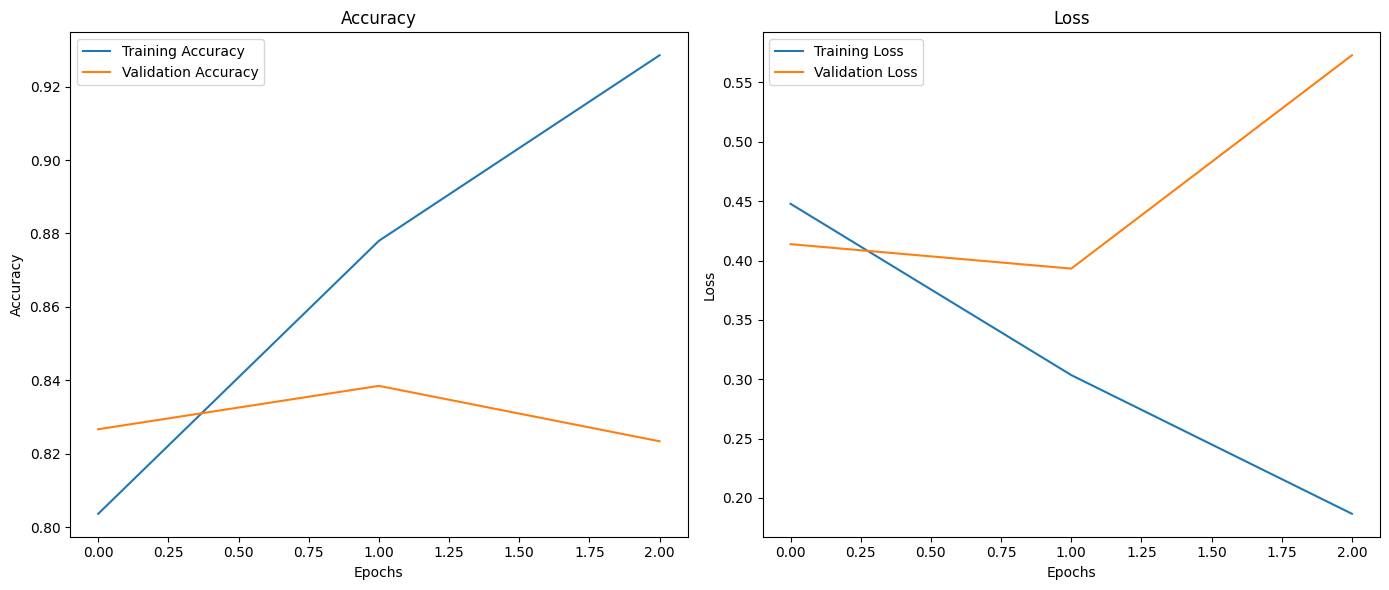

In [56]:

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
